# Sharing of clonotypes between repertoires

Here we will make the following figures:

  * Venn diagram of shared clonotypes between animals (**Figure 4a**)
  * Animal clonotypes shared with total human clonotype pool (**Figure 4b**)
  * CDRH3 length distributions for shared and unshared fractions (**Figure 4c**)
  * VH gene family usage for shared and unshared fractions (**Figure 4d**)
  * Sequence logos of 8 amino acid long CDRH3s from shared and unshared fractions (**Figure 4e**)
  * Sequence logos of 13 amino acid long CDRH3s from shared and unshared fractions (**Figure 4f**)
  
The raw data used to make these plots can be found [**here**](https://www.ncbi.nlm.nih.gov/bioproject/PRJNA592154).

The following Python packages are required to run the code in this notebook:
  * numpy
  * pandas
  * matplotlib
  * seaborn
  * weblogo

They can be install by running `pip install numpy pandas matplotlib seaborn weblogo`

In [33]:
import sys
import os

import itertools
import multiprocessing as mp
from collections import Counter
import math

import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.patches
import seaborn as sns

from weblogo import read_seq_data, LogoData, LogoOptions, LogoFormat, pdf_formatter, png_print_formatter
from weblogo.colorscheme import ColorScheme, IndexColor, SymbolColor

%matplotlib inline

In [28]:
def scale_and_normalize(df):
    '''
    This will scale the read counts for the samples 
    in the same way that DeSeq2 scales RNAseq reads
    and then will perform global normalization.
       - df input is a dataframe with read counts, 
         genes as rows, samples as columns.
    '''
    #First take the log of each read count
    df_log = np.log(df)
    
    #Then calculate the geometric mean across rows
    df_log['geometric mean'] = df_log.mean(axis=1)
    
    #Remove any genes that are not expressed by OmniRats
    df_log = df_log[df_log['geometric mean'] != np.NINF]
    
    #Get rid of the geometric mean column
    df_log = df_log.drop('geometric mean', 1)
    
    #Subtract each value from the mean of its columnn
    df_log = df_log.sub(df_log.mean(axis=1), axis=0)
    
    #Calculate scaling factors
    scaling_factors = []
    for median in list(df_log.median()):
        scaling_factors.append(math.exp(median))
    
    #Divide each column by the scaling factor
    for i, col in enumerate(df.columns):
        sf = scaling_factors[i]
        df[col] = df[col]/sf
        
    #remove where there is no expression
    #df = df[df.index.isin(df_log.index)]
    
    return df

# returns color of line for LN, Spleen or Human
def line_color(column):
    if column == 'Shared':
        return 'red'
    else:
        return 'blue'

def step(x, ys, colors=None, labels=None, figfile=None, figsize=(8, 3), color=[0.3] * 3,
                ylim=None, xlim=None, xtick_interval=1, linewidth=1.25, xlabel=None, show_legend=False):
    
    sns.set_style('white')

    # set some reasonable defaults (if not provided)
    if xlim is None:
        xlim = (-0.5, len(xs))
    if ylim is None:
        ylim = (0, 1.1 * max([max(y) for y in ys]))
    if colors is None:
        colors = sns.color_palette('muted', len(ys))
    if labels is None:
        labels = [None] * len(ys)

    # plot the data
    plt.figure(figsize=figsize)
    for y, color, label in zip(ys, colors, labels):
        plot = plt.step(x, y, where='mid', color=color, linewidth=linewidth, label=label)
        plt.fill_between(x, y, step='mid', color=color, alpha=0.2)

    # axis labels and ticks
    ax = plt.gca()
    ax.set_ylabel('Frequency', size=14, labelpad=8)
    if xlabel is not None:
        ax.set_xlabel(xlabel, size=14, labelpad=8)
    plt.xticks(x[::xtick_interval], x[::xtick_interval], size='medium')
    ax.tick_params(axis='x', which='major', labelsize=12)
    ax.tick_params(axis='y', which='major', labelsize=12, length=6, width=1.25, pad=12, right=False)
    
    # hide top, left and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # axis limits
    ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    
    # legend
    if show_legend:
        plt.legend(fontsize=12, handlelength=1)
    
    # save or show
    plt.tight_layout()
    if figfile is not None:
        plt.savefig(figfile, dpi=800)
    else:
        plt.show()

def mean_from_agg(values, freqs):
    values = np.array(values)
    freqs = np.array(freqs)
    arg_sorted = np.argsort(values)
    values = values[arg_sorted]
    freqs = freqs[arg_sorted]
    count = freqs.sum()
    fx = values * freqs
    mean = fx.sum() / count
    return mean

## Venn diagram of shared clonotypes between animals

To visualize the frequency of shared clonotypes between animals.

In [29]:
colors = sns.hls_palette(6, l=.6)
colors2 = sns.hls_palette(6, l=.3)

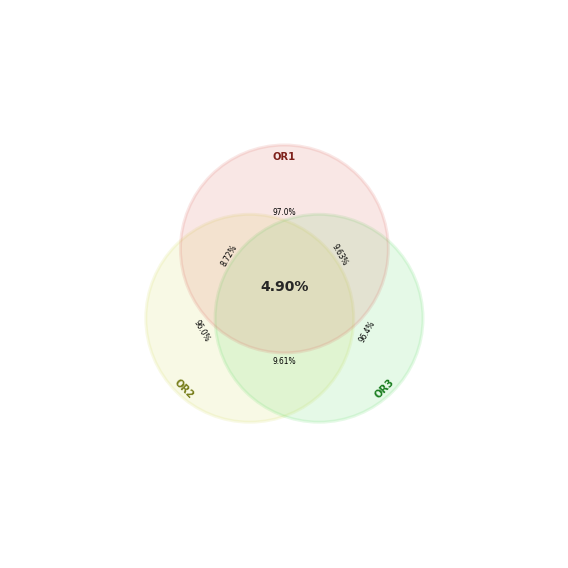

In [34]:
plt.figure(figsize=(8,8))
delta = 45.0  # degrees

angles = np.arange(0, 360 + delta, delta)
ells = []
ells.append(matplotlib.patches.Ellipse((-.5, -.5), 3, 3, 0, linewidth=3, color=colors[1], linestyle='-'))
ells.append(matplotlib.patches.Ellipse((.5, -.5), 3, 3, 0, linewidth=3, color=colors[2], linestyle='-'))
ells.append(matplotlib.patches.Ellipse((0, 0.5), 3, 3, 0, linewidth=3, color=colors[0], linestyle='-'))

a = plt.subplot(111, aspect='equal')


for e in ells:
    e.set_clip_box(a.bbox)
    e.set_alpha(0.15)
    a.add_artist(e)

a.tick_params(axis=u'both', which=u'both',length=0)

#plt.text(-1.75, 1.75, 'OR1', weight='bold', rotation=45, ha='center', color=colors2[3])
plt.text(0, 1.8, 'OR1', weight='bold', rotation=0, ha='center', color=colors2[0])
plt.text(1.45, -1.45, 'OR3', weight='bold', rotation=45, ha='center', color=colors2[2])
plt.text(-1.45, -1.45, 'OR2', weight='bold', rotation=-45, ha='center', color=colors2[1])

plt.text(0, -0.1, '4.90%', ha='center', size=14, weight='bold')
plt.text(0, 1, '97.0%', ha='center', color='black', size=7.5)
plt.text(-1.2, -0.6, '96.0%', ha='center', rotation=-60, color='black', size=7.5)
plt.text(1.2, -0.6, '96.4%', ha='center', rotation=60, color='black', size=7.5)
plt.text(0, -1.15, '9.61%', ha='center', color='black', size=7.5)
plt.text(-.8, 0.5, '8.72%', ha='center', rotation=60, color='black', size=7.5)
plt.text(.8, 0.5, '9.63%', ha='center', rotation=-60, color='black', size=7.5)

a.spines['top'].set_visible(False)
a.spines['right'].set_visible(False)
a.spines['left'].set_visible(False)
a.spines['bottom'].set_visible(False)
a.axes.get_xaxis().set_visible(False)
a.axes.get_yaxis().set_visible(False)

plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.tight_layout()
plt.savefig('./figures/figure4a', dpi=800)
plt.show()

## Animal clonotypes shared with total human clonotype pool

To visualize the frequency of OmniRat clonotypes shared with humans.

In [11]:
percent_shared = []
percent_shared.append({'Comparison': 'OR1', 'Percent Shared': 73765 / 557329, 'x': ' '})
percent_shared.append({'Comparison': 'OR2', 'Percent Shared': 97280 / 711227, 'x': ' '})
percent_shared.append({'Comparison': 'OR3', 'Percent Shared': 117738 / 989793, 'x': ' '})
percent_shared.append({'Comparison': 'OR Pool', 'Percent Shared': 291233 / 2115055, 'x': ' '})

df = pd.DataFrame(percent_shared)

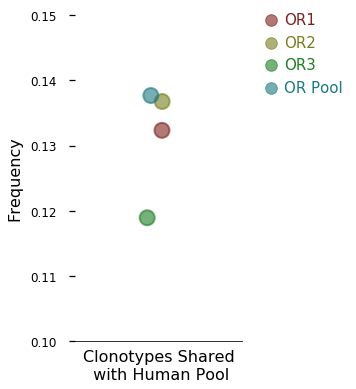

In [12]:
plt.figure(figsize=(3,6))
ax = sns.stripplot(data=df, x='x', y='Percent Shared', hue='Comparison',linewidth=2,edgecolor=colors2, palette=colors2, s=15, jitter=True, alpha=0.6)

ax.set_ylabel('Frequency', size=16, labelpad=8)
ax.set_xlabel('Clonotypes Shared\n with Human Pool', size=16, labelpad=8)
#ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12, length=6, width=1.25, pad=12, right=False)

legend = plt.legend(fontsize=15, bbox_to_anchor=(1, 1.05), markerscale=1.5, handletextpad=-.1)
legend.get_frame().set_linewidth(0.0)
for lh in legend.legendHandles: 
    lh.set_alpha(0.6)
for i, text in enumerate(legend.get_texts()):
    plt.setp(text, color = colors2[i])
# hide top, left and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([])

# axis limits
ax.set_ylim([0.1,0.15])

plt.savefig('./figures/figure4b', dpi=800, bbox_inches = "tight")
plt.show()

## CDRH3 length distributions for shared and unshared fractions


In [37]:
shared_vgenes = []
shared_jgenes = []
shared_cdr3aa = []
unshared_vgenes = []
unshared_jgenes = []
unshared_cdr3aa = []

with open('../Data/ORS-humans-shared.csv') as file:
    for line in file.readlines():
        vjcdr3aa = line.split(' ')
        shared_vgenes.append(vjcdr3aa[0])
        shared_jgenes.append(vjcdr3aa[1])
        shared_cdr3aa.append(vjcdr3aa[2])

with open('../Data/ORS-humans-unshared.csv') as file:
    for line in file.readlines():
        vjcdr3aa = line.split(' ')
        unshared_vgenes.append(vjcdr3aa[0])
        unshared_jgenes.append(vjcdr3aa[1])
        unshared_cdr3aa.append(vjcdr3aa[2])

In [38]:
cdr3_8aa_shared = [cdr3 for cdr3 in shared_cdr3aa if len(cdr3) == 9]
cdr3_8aa_unshared = [cdr3 for cdr3 in unshared_cdr3aa if len(cdr3) == 9]

cdr3_13aa_shared = [cdr3 for cdr3 in shared_cdr3aa if len(cdr3) == 14]
cdr3_13aa_unshared = [cdr3 for cdr3 in unshared_cdr3aa if len(cdr3) == 14]

shared_lens = [len(cdr3) for cdr3 in shared_cdr3aa]
unshared_lens = [len(cdr3) for cdr3 in unshared_cdr3aa]

cdr3_lens = {}
cdr3_lens['Shared'] = dict(Counter(shared_lens))
cdr3_lens['Unshared'] = dict(Counter(unshared_lens))

cdr3len_df = pd.DataFrame(cdr3_lens).fillna(0)

In [39]:
# Combine rat and human DFs
rat_and_human_df = cdr3len_df

# Scale and normalize the data
norm_cdrh3_df = scale_and_normalize(rat_and_human_df)

# Calculate the frequencies for each length
norm_average_cdrh3_df = norm_cdrh3_df / norm_cdrh3_df.sum()

/gpfs/ims/home/cjoyce/tools/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


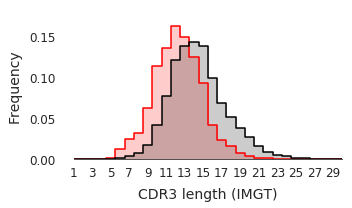

In [40]:
norm_average_cdrh3_values = norm_average_cdrh3_df.index.values
labels = norm_average_cdrh3_df.columns.values
ys = [list(norm_average_cdrh3_df[l]) for l in labels]
colors = ['r', 'k']

step(norm_average_cdrh3_values, ys, colors=colors, labels=labels, xlim=[1, 30], xtick_interval=2,
     figsize=(5, 3), linewidth=1.5, xlabel='CDR3 length (IMGT)', show_legend=False,
     figfile='./figures/figure4c'
    )

## VH gene family usage for shared and unshared fractions

In [26]:
vgene_data = {}
vgene_data['Shared']= dict(Counter(shared_vgenes))
vgene_data['Unshared']= dict(Counter(unshared_vgenes))

shared_vgenes_family = [vg.split('-')[0].replace('IGHV', 'VH') for vg in shared_vgenes]
unshared_vgenes_family = [vg.split('-')[0].replace('IGHV', 'VH') for vg in unshared_vgenes]

vfams = {}
vfams['Shared'] = dict(Counter(shared_vgenes_family))
vfams['Unshared'] = dict(Counter(unshared_vgenes_family))

vfam_df = pd.DataFrame(vfams)
vfam_df = vfam_df/vfam_df.sum()
vfam_df = vfam_df.reset_index().melt(id_vars='index',value_name='Count', var_name='property')

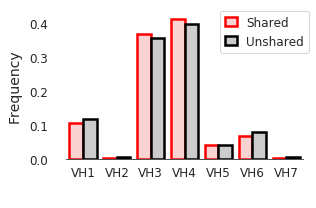

In [36]:
plt.figure(figsize=(4.5,3))
ax = sns.barplot(data=vfam_df, x='index', y='Count', hue='property', dodge=True, palette=['#FFCCCC', '#CCCCCC'],
                 linewidth=2.5, capsize=.2)
ax.set_ylabel('Frequency', size=14, labelpad=8)
ax.set_xlabel(' ', size=14, labelpad=8)
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='y', which='major', labelsize=12, length=6, width=1.25, pad=12, right=False)
edgeclrs = ['r']*7 + ['k']*7
for i, ipatch in enumerate(ax.patches):
    clr=edgeclrs[i]
    ipatch.set_edgecolor(clr)

plt.legend(fontsize=12, handlelength=1, bbox_to_anchor=(1.05, 1.05))
# hide top, left and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# axis limits
#ax.set_ylim([0,0.4])

# save or show
plt.tight_layout()
plt.savefig('./figures/figure4d', dpi=800)
plt.show()

## Sequence logos of 8 amino acid long CDRH3s from shared and unshared fractions

In [41]:
cdr3_8aa_shared_file = '../Data/cdr3_8aa_shared.fasta'
with open(cdr3_8aa_shared_file, 'w') as file:
    for i, seq in enumerate(cdr3_8aa_shared):
        s = seq.split('\n')[0]
        file.write('>Seq{}\n{}\n'.format(i,s))

cdr3_8aa_unshared_file = '../Data/cdr3_8aa_unshared.fasta'
with open(cdr3_8aa_unshared_file, 'w') as file:
    for i, seq in enumerate(cdr3_8aa_unshared):
        s = seq.split('\n')[0]
        file.write('>Seq{}\n{}\n'.format(i,s))

In [42]:
opts_kwargs = {'unit_name': 'probability',
               'show_xaxis': False,
               'show_yaxis': False,
               'show_fineprint': False,
               'stack_aspect_ratio': 3}

rules_8AA = [IndexColor(range(3), '#C0C0C0'),
             IndexColor(range(5, 8), '#C0C0C0'),
             SymbolColor("GSTYC", "green", "polar"),
             SymbolColor("NQ", "purple", "neutral"),
             SymbolColor("KRH", "blue", "basic"),
             SymbolColor("DE", "red", "acidic"),
             SymbolColor("PAWFLIMV", "black", "hydrophobic")]

colorscheme_8AA = ColorScheme(rules_8AA)

options = LogoOptions(**opts_kwargs)
options.color_scheme = colorscheme_8AA

In [43]:
files_8AA = {'Shared': cdr3_8aa_shared_file,
             'Unshared': cdr3_8aa_unshared_file}

for prefix, seq_file in files_8AA.items():
    with open(seq_file) as f:
        seqs = read_seq_data(f)
        data = LogoData.from_seqs(seqs)
        fmt = LogoFormat(data, options)
        eps = png_print_formatter(data, fmt)
        with open('./figures/figure4e{}_8AA_weblogo.png'.format(prefix), 'wb') as eps_file:
            eps_file.write(eps)

## Sequence logos of 13 amino acid long CDRH3s from shared and unshared fractions

In [44]:
cdr3_13aa_shared_file = '../Data/cdr3_13aa_shared.fasta'
with open(cdr3_13aa_shared_file, 'w') as file:
    for i, seq in enumerate(cdr3_13aa_shared):
        s = seq.split('\n')[0]
        file.write('>Seq{}\n{}\n'.format(i,s))

cdr3_13aa_unshared_file = '../Data/cdr3_13aa_unshared.fasta'
with open(cdr3_13aa_unshared_file, 'w') as file:
    for i, seq in enumerate(cdr3_13aa_unshared):
        s = seq.split('\n')[0]
        file.write('>Seq{}\n{}\n'.format(i,s))

In [45]:
rules_13AA = [IndexColor(range(3), '#C0C0C0'),
              IndexColor(range(10, 13), '#C0C0C0'),
              SymbolColor("GSTYC", "green", "polar"),
              SymbolColor("NQ", "purple", "neutral"),
              SymbolColor("KRH", "blue", "basic"),
              SymbolColor("DE", "red", "acidic"),
              SymbolColor("PAWFLIMV", "black", "hydrophobic")]

colorscheme_13AA = ColorScheme(rules_13AA)

options = LogoOptions(**opts_kwargs)
options.color_scheme = colorscheme_13AA

In [46]:
files_13AA = {'Shared': cdr3_13aa_shared_file,
             'Unshared': cdr3_13aa_unshared_file}

In [47]:
for prefix, seq_file in files_13AA.items():
    with open(seq_file) as f:
        seqs = read_seq_data(f)
        data = LogoData.from_seqs(seqs)
        fmt = LogoFormat(data, options)
        eps = png_print_formatter(data, fmt)
        with open('./figures/figure4e{}_13AA_weblogo.png'.format(prefix), 'wb') as eps_file:
            eps_file.write(eps)